In [3]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from math import ceil
from skimage import data
from skimage.metrics import peak_signal_noise_ratio as sk_psnr
from skimage.metrics import structural_similarity as sk_ssim
    

In [4]:
def psf_motion(length=15, angle=0):
    size = int(ceil(length))
    if size % 2 == 0:
        size += 1
    kernel = np.zeros((size, size), dtype=np.float32)
    center = size // 2
    theta = np.deg2rad(angle)
    dx, dy = np.cos(theta), np.sin(theta)
    
    coords = np.linspace(-(length - 1) / 2.0, (length - 1) / 2.0, num=size)
    for t in coords:
        x = int(round(center + dx * t))
        y = int(round(center + dy * t))
        if 0 <= y < size and 0 <= x < size:
            kernel[y, x] = 1.0
            
    return kernel / kernel.sum()

def pad_to_shape(img, shape):
    out = np.zeros(shape, dtype=img.dtype)
    ih, iw = img.shape
    out[:ih, :iw] = img
    return out

def degrade_image(img, psf, noise_sigma=0.01):
    # Convert image and PSF to frequency domain
    IMG = np.fft.fft2(img)
    PSF = np.fft.fft2(np.fft.ifftshift(pad_to_shape(psf, img.shape)))
    
    # Apply blur by multiplying in the frequency domain
    blurred = np.fft.ifft2(IMG * PSF).real
    
    # Add noise and clip the values to the valid range [0, 1]
    noisy = blurred + np.random.normal(scale=noise_sigma, size=blurred.shape)
    return np.clip(noisy, 0, 1)

In [5]:
def inverse_filter(blurred, psf, eps=1e-3):
    IMG = np.fft.fft2(blurred)
    PSF = np.fft.fft2(np.fft.ifftshift(pad_to_shape(psf, blurred.shape)))
    
    # Avoid division by zero by setting a small threshold (eps)
    denom = PSF.copy()
    denom[np.abs(denom) < eps] = eps
    
    restored = np.fft.ifft2(IMG / denom).real
    return np.clip(restored, 0, 1)

def wiener_filter(blurred, psf, K=0.01):
    IMG = np.fft.fft2(blurred)
    PSF = np.fft.fft2(np.fft.ifftshift(pad_to_shape(psf, blurred.shape)))
    
    # Wiener filter formula
    H_conj = np.conj(PSF)
    denom = (np.abs(PSF) ** 2) + K
    
    restored = np.fft.ifft2((H_conj / denom) * IMG).real
    return np.clip(restored, 0, 1)

In [6]:
def compute_psnr(a, b):
    if SKIMAGE:
        return sk_psnr(a, b, data_range=1.0)
    # Fallback implementation if scikit-image is not available
    mse = np.mean((a - b) ** 2)
    if mse == 0:
        return 99.0
    return 10 * np.log10(1.0 / mse)

def compute_ssim(a, b):
    if SKIMAGE:
        return sk_ssim(a, b, data_range=1.0)
    return None # No fallback for SSIM

In [7]:
# Create a directory for images if it doesn't exist
os.makedirs("images", exist_ok=True)

image_paths = glob.glob("images/*")

# If no images are found, download samples from scikit-image
if len(image_paths) == 0 and SKIMAGE:
    print("No images found. Downloading sample images from scikit-image.")
    samples = [data.camera(), data.coins()]
    for i, arr in enumerate(samples):
        path = f"images/sample_{i+1}.png"
        Image.fromarray(arr).save(path)
        image_paths.append(path)

# Load images from the directory
images = []
for p in image_paths:
    try:
        im = Image.open(p).convert('L') # Convert to grayscale
        arr = np.array(im).astype(np.float32) / 255.0 # Normalize to [0, 1]
        images.append((os.path.basename(p), arr))
    except Exception as e:
        print(f"Could not load {p}: {e}")

if images:
    print(f"\nSuccessfully loaded {len(images)} images.")
else:
    print("\nWarning: No images loaded. Please place image files in the 'images' directory.")


Successfully loaded 5 images.


--------------------------------------------------
Processing: 8_bit_image.jpeg
Degraded: PSNR=9.64, SSIM=0.258
Inverse Filter:  PSNR=5.65, SSIM=0.004
Wiener Filter:   PSNR=21.23, SSIM=0.291


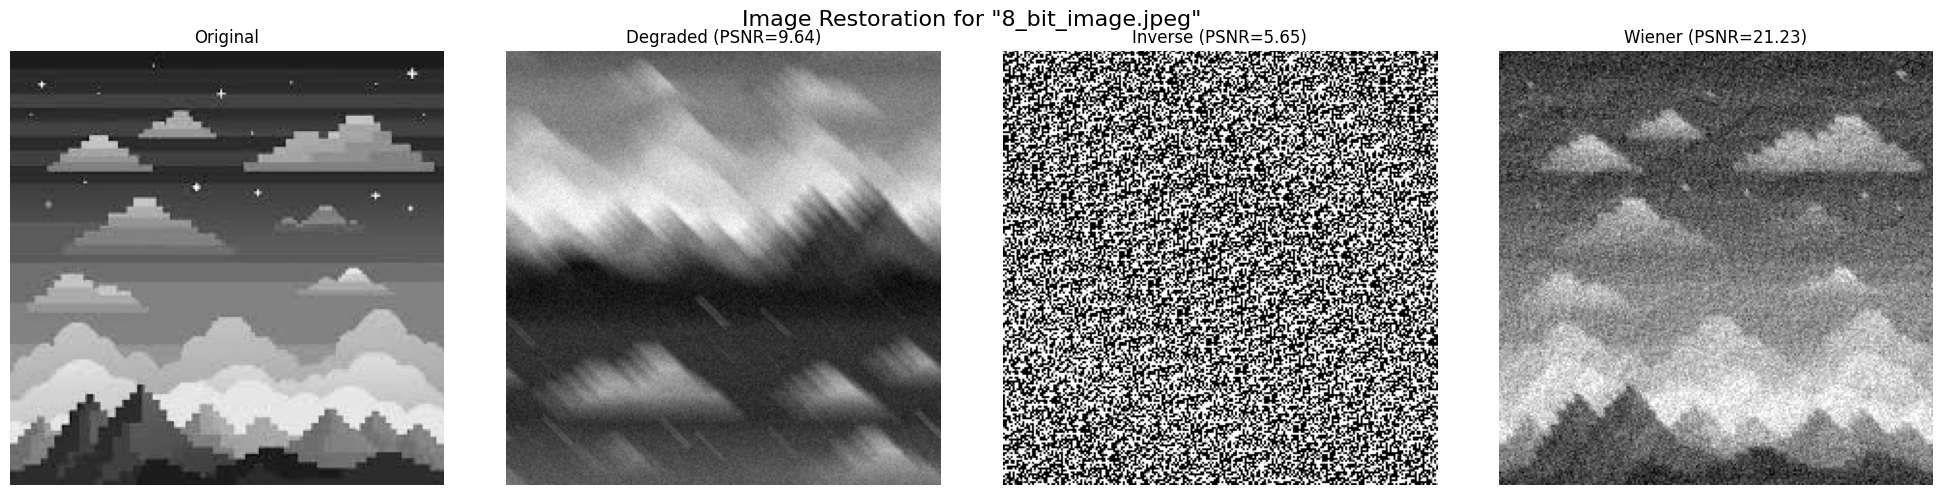

--------------------------------------------------
Processing: Alsetch Glacier.jpg
Degraded: PSNR=10.36, SSIM=0.344
Inverse Filter:  PSNR=6.05, SSIM=0.009
Wiener Filter:   PSNR=21.25, SSIM=0.246


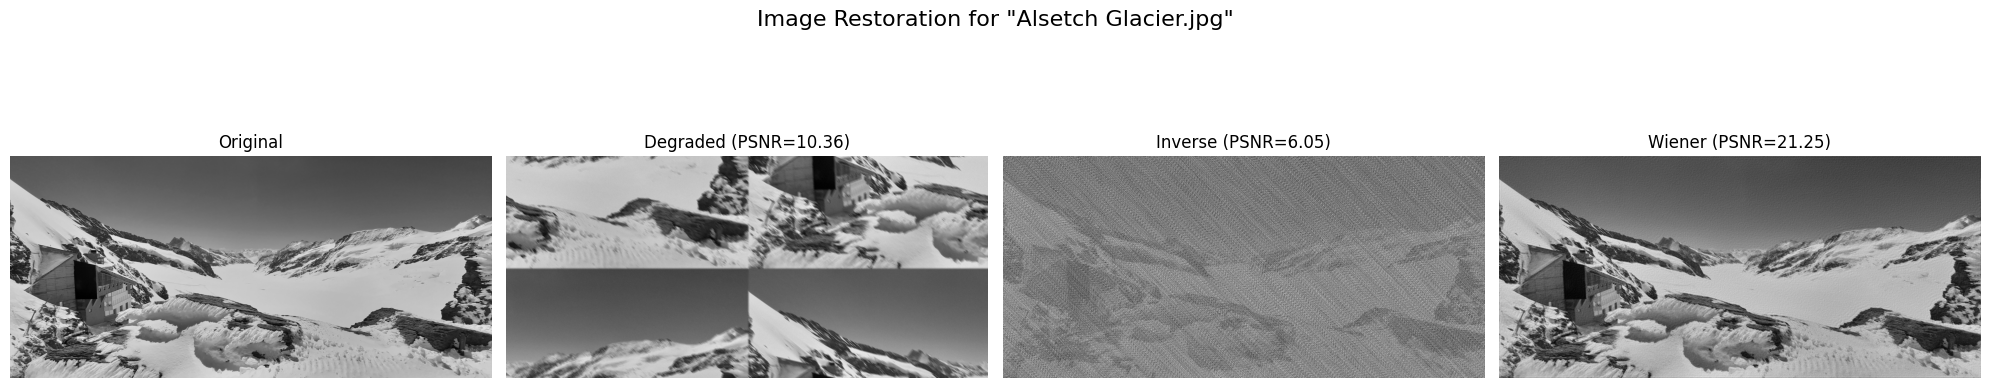

--------------------------------------------------
Processing: mountains.jpg
Degraded: PSNR=11.29, SSIM=0.187
Inverse Filter:  PSNR=6.03, SSIM=0.016
Wiener Filter:   PSNR=20.31, SSIM=0.356


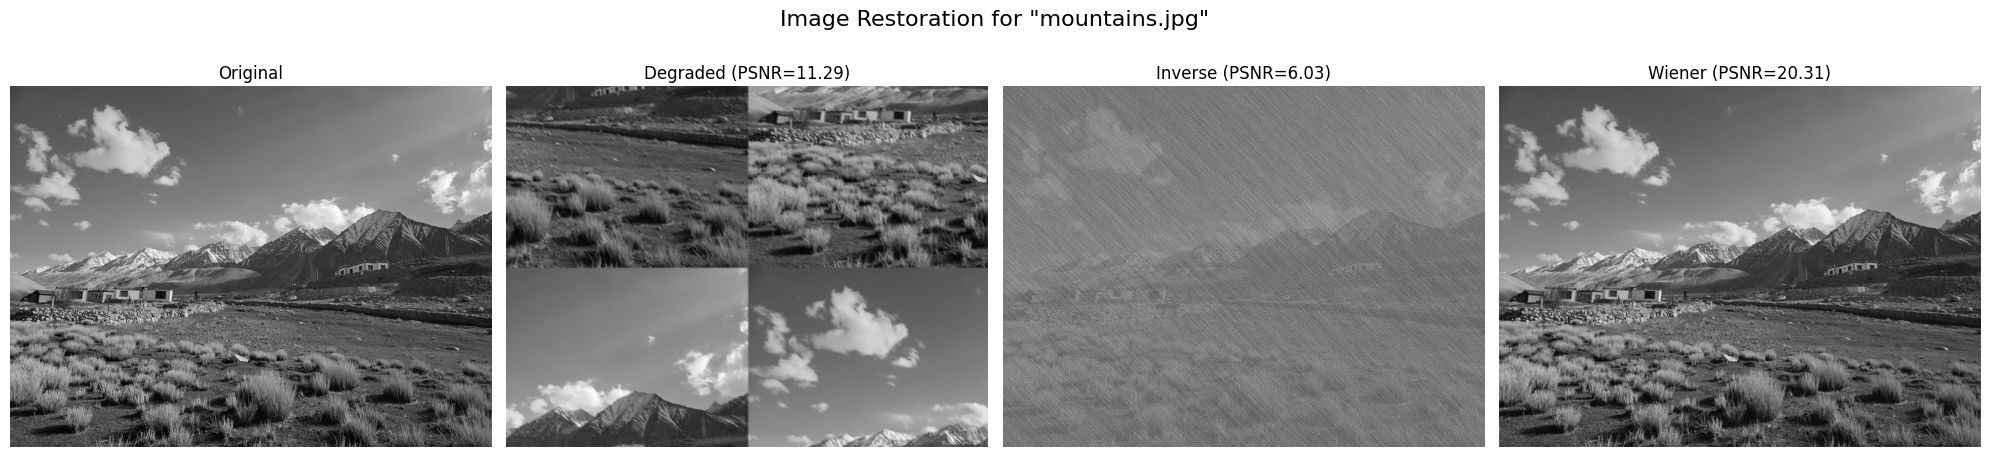

--------------------------------------------------
Processing: watermark.jpeg
Degraded: PSNR=26.86, SSIM=0.557
Inverse Filter:  PSNR=3.87, SSIM=0.004
Wiener Filter:   PSNR=14.16, SSIM=0.699


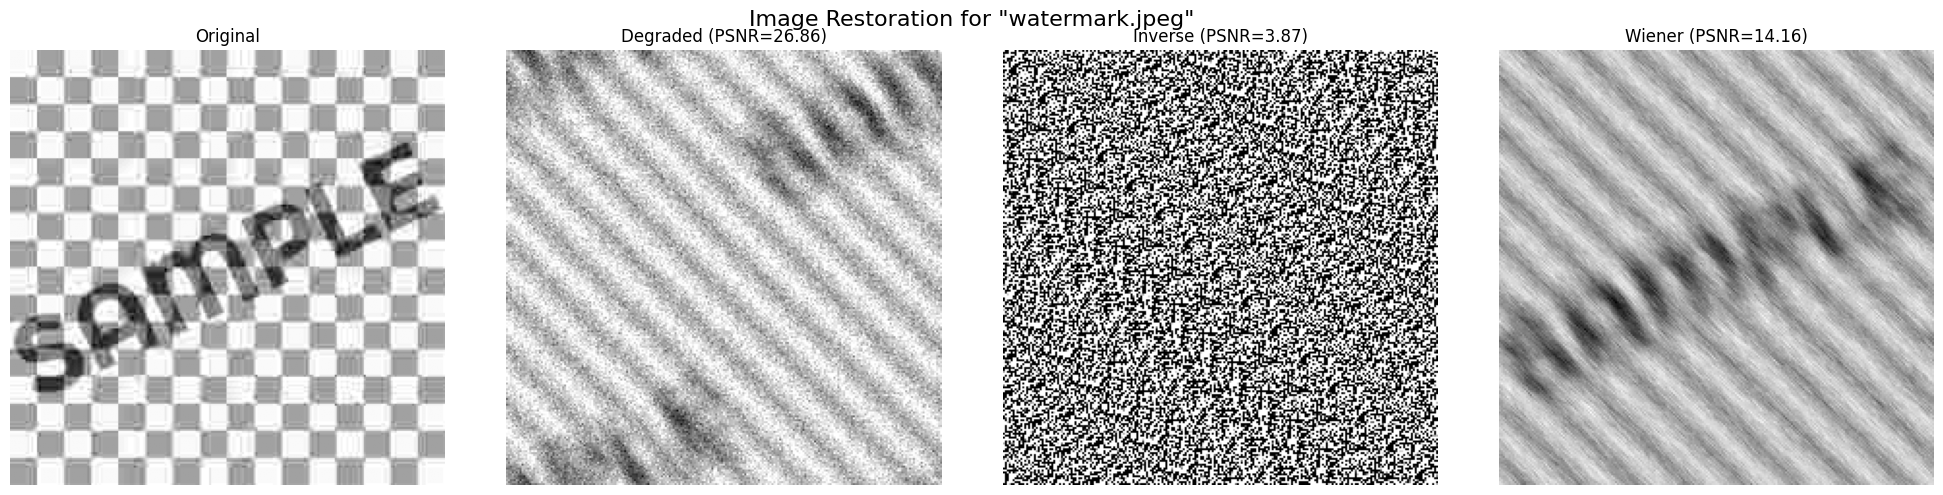

--------------------------------------------------
Processing: watermark.png
Degraded: PSNR=26.88, SSIM=0.556
Inverse Filter:  PSNR=3.98, SSIM=0.004
Wiener Filter:   PSNR=14.16, SSIM=0.699


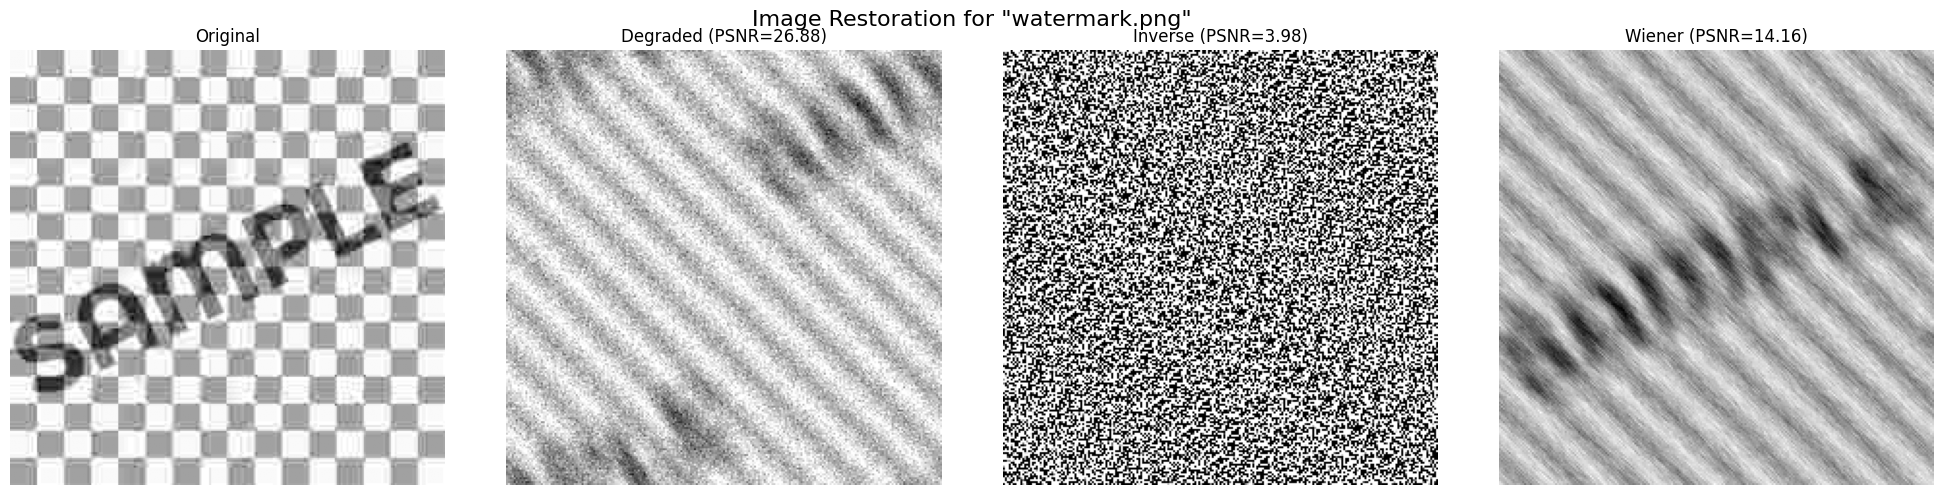

In [8]:
# --- Parameters ---
BLUR_LENGTH = 20
BLUR_ANGLE = 45
NOISE_SIGMA = 0.02

# Create the motion blur PSF
psf = psf_motion(length=BLUR_LENGTH, angle=BLUR_ANGLE)

# Process each loaded image
for name, img in images:
    # 1. Degrade the original image
    degraded = degrade_image(img, psf, NOISE_SIGMA)
    
    # 2. Restore using Inverse Filter
    inv_restored = inverse_filter(degraded, psf)
    
    # 3. Restore using Wiener Filter
    # Estimate K as the noise-to-signal power ratio
    signal_power = np.var(img)
    noise_power = NOISE_SIGMA**2
    K = noise_power / (signal_power + 1e-12) # Add small epsilon to avoid division by zero
    wien_restored = wiener_filter(degraded, psf, K)

    # 4. Compute metrics
    psnr_degraded = compute_psnr(img, degraded)
    psnr_inv = compute_psnr(img, inv_restored)
    psnr_wien = compute_psnr(img, wien_restored)
    
    ssim_degraded = compute_ssim(img, degraded)
    ssim_inv = compute_ssim(img, inv_restored)
    ssim_wien = compute_ssim(img, wien_restored)

    # 5. Print results and display images
    print("-" * 50)
    print(f"Processing: {name}")
    print(f"Degraded: PSNR={psnr_degraded:.2f}, SSIM={ssim_degraded:.3f}")
    print(f"Inverse Filter:  PSNR={psnr_inv:.2f}, SSIM={ssim_inv:.3f}")
    print(f"Wiener Filter:   PSNR={psnr_wien:.2f}, SSIM={ssim_wien:.3f}")
    
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f'Image Restoration for "{name}"', fontsize=16)
    
    ax[0].imshow(img, cmap='gray'); ax[0].set_title('Original'); ax[0].axis('off')
    ax[1].imshow(degraded, cmap='gray'); ax[1].set_title(f'Degraded (PSNR={psnr_degraded:.2f})'); ax[1].axis('off')
    ax[2].imshow(inv_restored, cmap='gray'); ax[2].set_title(f'Inverse (PSNR={psnr_inv:.2f})'); ax[2].axis('off')
    ax[3].imshow(wien_restored, cmap='gray'); ax[3].set_title(f'Wiener (PSNR={psnr_wien:.2f})'); ax[3].axis('off')
    
    plt.tight_layout()
    plt.show()